# Getting started with hierarchical HEALPix data

The data used in the hackathon is not stored using traditional lat/lon coordinates but rather it uses the **HEALPix** format which was originally created by Astrophysicists. 

For more information on this dataset, see 

https://easy.gems.dkrz.de/Processing/healpix/index.html

## The catalog and dataset

This notebook is a version of

https://easy.gems.dkrz.de/Processing/healpix/healpix_starter.html

adapted for our datastructures on gadi.

The HEALpix format is a hierachical format which allows us to store multiple resolutions of the same dataset.  These resolutions are referred to as 'zoom levels'. 


We found that concatenating datasets tends to be much more complicated than subselecting.
Thus, for the hierarchical HEALPix output, we aim at creating one single `Dataset` for a model run (including all variables and timesteps).
This `Dataset` should still be accessed through an `intake` catalog, as the catalog provides a way for dataset maintainers to optimize access to the data without affecting scripts using the data.

### The dataset
Long story short, let's have a look at the output of the nextGEMS Cycle 3 `ICON` run `ngc3028` though the catalog `cat`:

```{code-cell} ipython3
import intake

cat = intake.open_catalog("https://data.nextgems-h2020.eu/catalog.yaml")
ds = cat.ICON.ngc3028.to_dask()  # this does NOT use dask, see note below
ds
```




### The catalog

The catalog entry is parameterized by `zoom` and `time` in order to implement hierarchical data access. Here's how this looks like:

![dataset hierarchy](./ds_hierarchy.png)

So while technically, there's an independent `Dataset` for each combination of the `zoom` and `time` parameters, it's better to picture all the datasets as copies of the same thing, only their coordinates are of course different due to the different resolutions.
The only exception being, that some variables are missing in finer temporal resolutions (e.g. ocean and 3D variables), but generally all variables available at fine resolutions are **also** available at coarse resolutions.

Let's see which parameter values are available (you can ommit the `pandas` part, but it looks nicer):

```{code-cell} ipython3
import pandas as pd

pd.DataFrame(cat.ICON.ngc3028.describe()["user_parameters"])
```

So just as in the picture above, we have `time` and `zoom` parameters.
`time` resolution is given as [ISO duration strings](https://en.wikipedia.org/wiki/ISO_8601#Durations), `zoom` are the number of bisections in the healpix grid (e.g. the data will have $12 \cdot 4^{zoom}$ cells).
The coarsest settings are the default.
The default is well suited to e.g. obtain the trend of global mean surface temperatures:

In [1]:
# Substitute our own data zoom 2
import xarray as xr
from pathlib import Path

data_2d_z2 = "/g/data/qx55/uk_node/glm.n2560_RAL3p3/data.healpix.PT1H.z2.zarr" #PT1H is hourly data
ds_2 = xr.open_zarr(data_2d_z2)
ds_2

<xarray.Dataset> Size: 193MB
Dimensions:  (cell: 192, time: 10489)
Coordinates:
  * cell     (cell) int64 2kB 0 1 2 3 4 5 6 7 ... 185 186 187 188 189 190 191
    crs      float64 8B ...
  * time     (time) datetime64[ns] 84kB 2020-01-20 ... 2021-04-01
Data variables: (12/24)
    clivi    (time, cell) float32 8MB dask.array<chunksize=(4096, 192), meta=np.ndarray>
    clt      (time, cell) float32 8MB dask.array<chunksize=(4096, 192), meta=np.ndarray>
    clwvi    (time, cell) float32 8MB dask.array<chunksize=(4096, 192), meta=np.ndarray>
    hflsd    (time, cell) float32 8MB dask.array<chunksize=(4096, 192), meta=np.ndarray>
    hfssd    (time, cell) float32 8MB dask.array<chunksize=(4096, 192), meta=np.ndarray>
    huss     (time, cell) float32 8MB dask.array<chunksize=(4096, 192), meta=np.ndarray>
    ...       ...
    rsut     (time, cell) float32 8MB dask.array<chunksize=(4096, 192), meta=np.ndarray>
    rsutcs   (time, cell) float32 8MB dask.array<chunksize=(4096, 192), meta=np.ndarray>
    tas      (time, cell) float32 8MB dask.array<chunksize=(4096, 192), meta=np.ndarray>
    ts       (time, cell) float32 8MB dask.array<chunksize=(4096, 192), meta=np.ndarray>
    uas      (time, cell) float32 8MB dask.array<chunksize=(4096, 192), meta=np.ndarray>
    vas      (time, cell) float32 8MB dask.array<chunksize=(4096, 192), meta=np.ndarray>
Attributes:
    Met Office DYAMOND3 simulations:  A group of experiments have been conduc...
    bounds:                           {'lower_left_lat': -90, 'lower_left_lon...
    latitiude_convention:             [-90, 90]
    longitude_convention:             [0, 360]
    regional:                         False
    simulation:                       glm.n2560_RAL3p3
    simulation_description:           The MetUM uses a regular lat-lon grid, ...

You can get an overview over all output variables by inspecting the retrieved dataset `ds`.
The dimensions of each variable show if they are 2D or 3D variables, the attributes inform e.g. about the model `component` which generated that variable or the `cell_methods` which have been applied if a variable has been aggregated.

In [2]:
ds_2.tas

<xarray.DataArray 'tas' (time: 10489, cell: 192)> Size: 8MB
dask.array<open_dataset-tas, shape=(10489, 192), dtype=float32, chunksize=(4096, 192), chunktype=numpy.ndarray>
Coordinates:
  * cell     (cell) int64 2kB 0 1 2 3 4 5 6 7 ... 185 186 187 188 189 190 191
    crs      float64 8B ...
  * time     (time) datetime64[ns] 84kB 2020-01-20 ... 2021-04-01
Attributes:
    STASH:          [1, 3, 236]
    UM_name:        air_temperature
    grid_mapping:   healpix_nested
    healpix_zoom:   2
    long_name:      air_temperature
    source:         Data from Met Office Unified Model
    standard_name:  air_temperature
    um_version:     13.5
    units:          K

In [3]:
ds_2.time

<xarray.DataArray 'time' (time: 10489)> Size: 84kB
array(['2020-01-20T00:00:00.000000000', '2020-01-20T01:00:00.000000000',
       '2020-01-20T02:00:00.000000000', ..., '2021-03-31T22:00:00.000000000',
       '2021-03-31T23:00:00.000000000', '2021-04-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    crs      float64 8B ...
  * time     (time) datetime64[ns] 84kB 2020-01-20 ... 2021-04-01

In [4]:
ds_2.tas.mean("cell").values[:40]

array([285.60684, 285.5228 , 285.5084 , 285.59396, 285.68823, 285.8097 ,
       285.9326 , 286.05273, 286.15973, 286.2287 , 286.269  , 286.2883 ,
       286.29532, 286.29224, 286.2776 , 286.2363 , 286.162  , 286.0679 ,
       285.96936, 285.88977, 285.817  , 285.74313, 285.6648 , 285.5928 ,
       285.54446, 285.547  , 285.60886, 285.6898 , 285.77505, 285.88864,
       286.00327, 286.12024, 286.229  , 286.29904, 286.33432, 286.34946,
       286.35498, 286.3497 , 286.33472, 286.29327], dtype=float32)

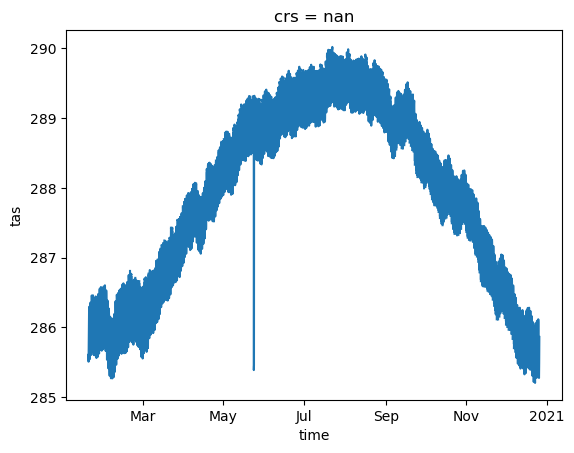

In [5]:
ds_2.tas.mean("cell").plot()

If you are interested in daily variablility, it might however be important to change temporal resolution to a finer scale:

```{code-cell} ipython3
ds_fine = cat.ICON.ngc3028(
    time="PT30M"
).to_dask()  # this does NOT use dask, see note below
ds_fine.tas.mean("cell").plot()
```

For sure, the `12` horizontal cells won't provide a detailed map, but let's check quickly.

In [6]:
data_2d_z2 = "/g/data/qx55/uk_node/glm.n2560_RAL3p3/data.healpix.PT1H.z2.zarr"
ds_2 = xr.open_zarr(data_2d_z2)

data_2d_z3 = "/g/data/qx55/uk_node/glm.n2560_RAL3p3/data.healpix.PT1H.z3.zarr"
ds_3 = xr.open_zarr(data_2d_z3)

data_2d_z4 = "/g/data/qx55/uk_node/glm.n2560_RAL3p3/data.healpix.PT1H.z4.zarr"
ds_4 = xr.open_zarr(data_2d_z4)

data_2d_z5 = "/g/data/qx55/uk_node/glm.n2560_RAL3p3/data.healpix.PT1H.z5.zarr"
ds_5 = xr.open_zarr(data_2d_z5)

In [7]:
ds_dict = {2:ds_2.tas, 3:ds_3.tas, 4:ds_4.tas, 5:ds_5.tas}

Plotting with easygems in conjuction with matplotlib and cartopy

In [8]:
import matplotlib.pyplot as plt
import easygems.healpix as egh
import cartopy.crs as ccrs

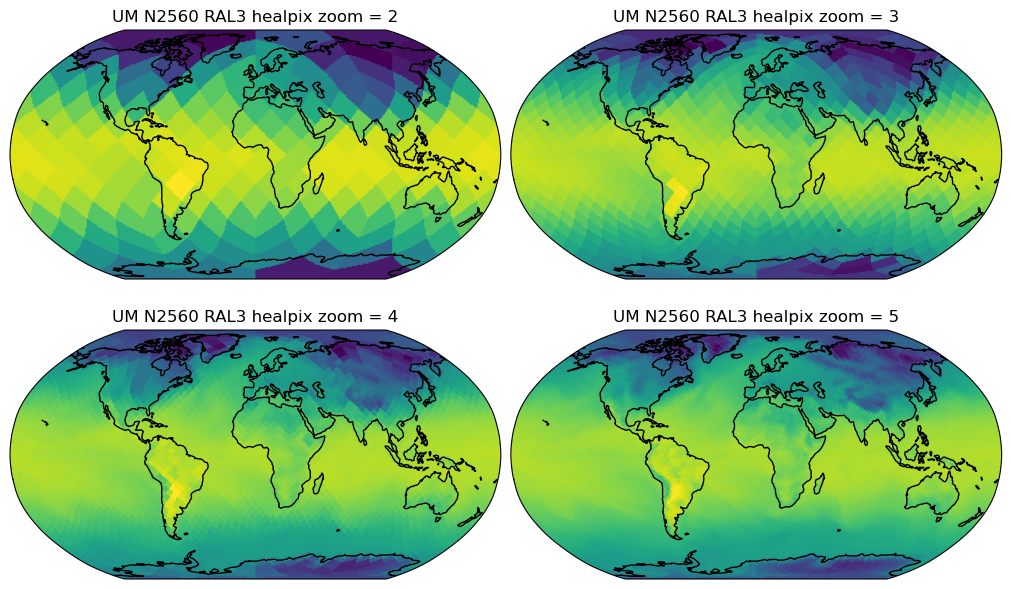

In [9]:
projection = ccrs.Robinson(central_longitude=0)

fig, axes = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={'projection': projection}, layout='constrained')

for ax, (name, da) in zip(axes.flatten(), ds_dict.items()):
    data = da.isel(time=20)
    ax.set_global()
    im = egh.healpix_show(data.values,ax=ax)
    ax.coastlines()
    ax.set_title(f'UM N2560 RAL3 healpix zoom = {name}')
    #print (ax, name, da)


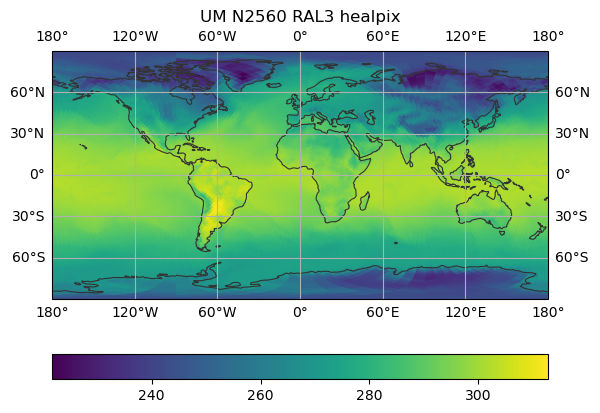

In [10]:
# Plotting lat/lon values over the grid
projection=ccrs.PlateCarree(central_longitude=0.0)

ax = egh.create_geoaxis(add_coastlines=True,projection=projection)
im = egh.healpix_show(data.values, ax=ax, add_coastlines=True)
ax.set_title(f'UM N2560 RAL3 healpix')
ax.gridlines(draw_labels=True)
fig=ax.get_figure()
fig.colorbar(im,orientation='horizontal')

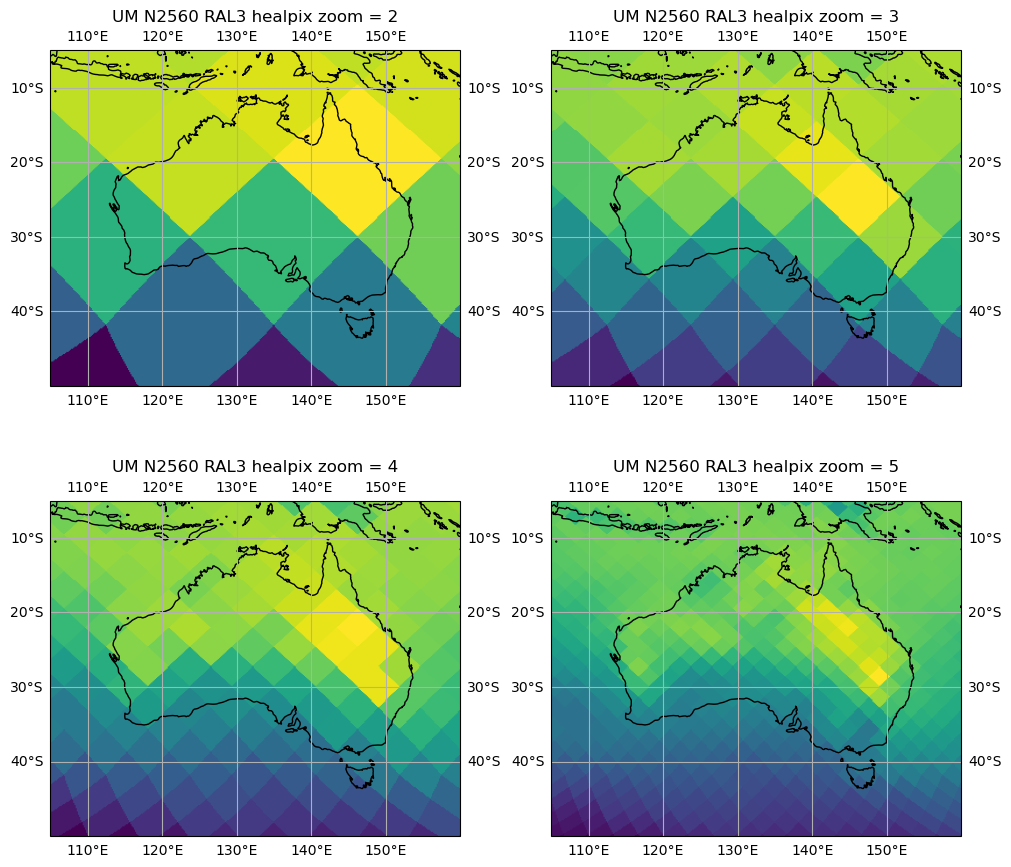

In [11]:
# Plotting the above, over Australia with all zoom levels.

# Note - we still have to use the egh wrapper functions to plot the healpix gridded data
# onto a lat/lon grid
projection = ccrs.PlateCarree(central_longitude=0)

fig, axes = plt.subplots(2, 2, figsize=(10, 9), subplot_kw={'projection': projection}, layout='constrained')

for ax, (name, da) in zip(axes.flatten(), ds_dict.items()):
    data = da.isel(time=0)
    ax.set_extent([105, 160,-50, -5], crs=ccrs.PlateCarree())
    im = egh.healpix_show(data.values,ax=ax)
    ax.coastlines()
    ax.set_title(f'UM N2560 RAL3 healpix zoom = {name}')
    ax.gridlines(draw_labels=True)


In [12]:
# Examining the grid over Australia and re-sampling to a lat-lon grid
import numpy as np
import healpy as hp

def get_nn_lon_lat_index(nside, lons, lats):
    lons2, lats2 = np.meshgrid(lons, lats)
    return xr.DataArray(
        hp.ang2pix(nside, lons2, lats2, nest=True, lonlat=True),
        coords=[("lat", lats), ("lon", lons)],
    )

cells=get_nn_lon_lat_index(2, np.linspace(-180, 180, 800), np.linspace(-90, 90, 400))

This returns a dataarray which tells you which cell number is occupies a grid with 0.55 x 0.5 resolution

In [13]:
cells

<xarray.DataArray (lat: 400, lon: 800)> Size: 3MB
array([[40, 40, 40, ..., 36, 36, 40],
       [40, 40, 40, ..., 36, 36, 40],
       [40, 40, 40, ..., 36, 36, 40],
       ...,
       [11, 11, 11, ...,  7,  7, 11],
       [11, 11, 11, ...,  7,  7, 11],
       [11, 11, 11, ...,  7,  7, 11]])
Coordinates:
  * lat      (lat) float64 3kB -90.0 -89.55 -89.1 -88.65 ... 89.1 89.55 90.0
  * lon      (lon) float64 6kB -180.0 -179.5 -179.1 -178.6 ... 179.1 179.5 180.0

Use the function to map healpix gridded data onto a lat/lon grid. Note - you have to match the level of zoom of the original grid. If you don't, you will under/over sample the original healpix data. Test for zoom = 4

In [14]:
zoom=4
idx = get_nn_lon_lat_index(
    2**zoom, np.linspace(100, 160, 300), np.linspace(-50, 5, 300)
)

In [15]:
tas_lon_lat = ds_4.tas.isel(time=0, cell=idx)
tas_lon_lat

<xarray.DataArray 'tas' (lat: 300, lon: 300)> Size: 360kB
dask.array<reshape, shape=(300, 300), dtype=float32, chunksize=(300, 300), chunktype=numpy.ndarray>
Coordinates:
    cell     (lat, lon) int64 720kB 2443 2443 2443 2443 ... 1713 1713 1713 1713
    crs      float64 8B ...
    time     datetime64[ns] 8B 2020-01-20
  * lat      (lat) float64 2kB -50.0 -49.82 -49.63 -49.45 ... 4.632 4.816 5.0
  * lon      (lon) float64 2kB 100.0 100.2 100.4 100.6 ... 159.6 159.8 160.0
Attributes:
    STASH:          [1, 3, 236]
    UM_name:        air_temperature
    grid_mapping:   healpix_nested
    healpix_zoom:   4
    long_name:      air_temperature
    source:         Data from Met Office Unified Model
    standard_name:  air_temperature
    um_version:     13.5
    units:          K

So we now have a dataarray with co-ordinates (lat/lon). This allows us to plot subsets of data, and to regrid

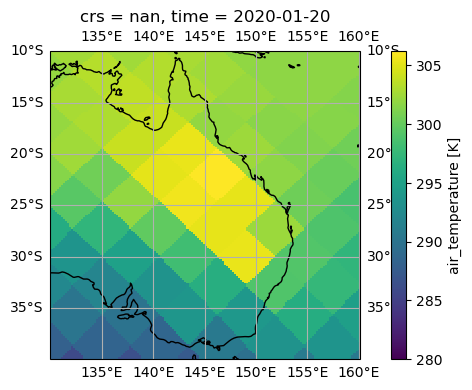

In [16]:
fig, ax = plt.subplots(figsize=(8, 4), subplot_kw={"projection": projection})
ax.coastlines()
ax.gridlines(draw_labels=True)
tas_lon_lat.sel(lat=slice(-40,-10),lon=slice(130,160)).plot(ax=ax,vmin=280)

In [17]:
 # Testing the idx subroutine with different zoom levels on the native zoom 4 data

In [18]:
# Create a dictionary of remappers for different zoom levels
idxs = {}

for zoom in range(1,5):
    idxs[zoom] =  get_nn_lon_lat_index(
                  2**zoom, np.linspace(100, 160, 300), np.linspace(-50, 5, 300)
                  )   

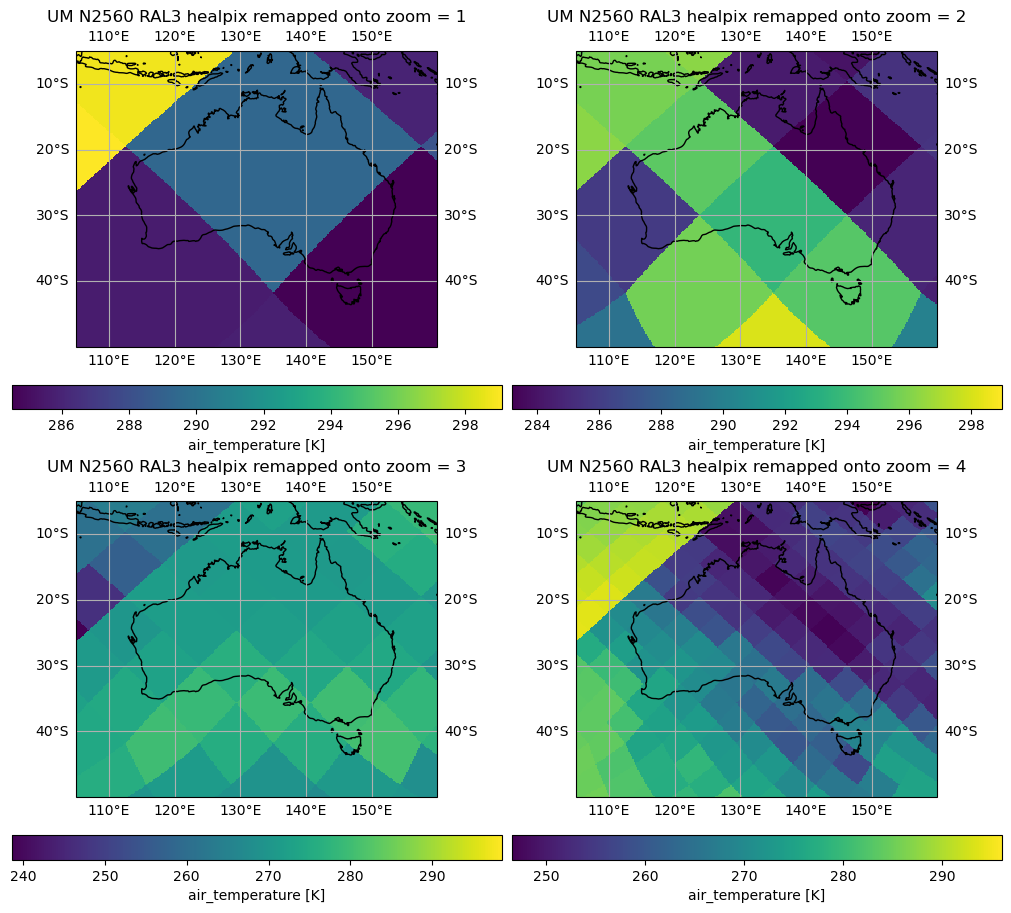

In [19]:
# Apply to our native dataset at zoom 4

projection = ccrs.PlateCarree(central_longitude=0)

fig, axes = plt.subplots(2, 2, figsize=(10, 9), subplot_kw={'projection': projection}, layout='constrained')

for ax, (zoom, idx) in zip(axes.flatten(), idxs.items()):
    data = da.isel(time=0,cell=idx)
    ax.set_extent([105, 160,-50, -5], crs=ccrs.PlateCarree())
    data.plot(ax=ax,cbar_kwargs={'orientation': 'horizontal'})
    ax.coastlines()
    ax.set_title(f'UM N2560 RAL3 healpix remapped onto zoom = {zoom}')
    ax.gridlines(draw_labels=True)


**NOTE:**

While the method for converting a catalog entry into a `Dataset` is called `.to_dask()`, it will **not** return a `dask`-backed `Dataset` by default. In many cases (in particular for doing some quick plots), `dask` is not really necessary. As the [dask best practices](https://docs.dask.org/en/stable/best-practices.html#start-small) suggest we should *Use better algorithms or data structures* instead of `dask` if you don't need it.


## Working with multiple resolutions

We can also mix resolutions to compare Hamburg's temperature to the global mean. To work with multiple resolutions of a single run, it might be useful to store the selected model run's catalog entry into a variable. We also need one further helper function (`get_nside`, also available in the `easygems` package), as well as `pylab`:

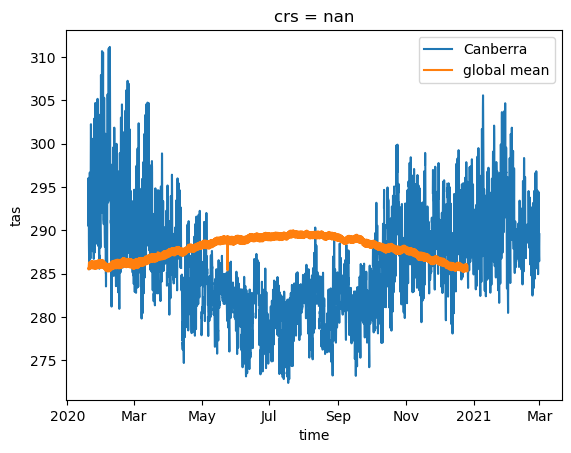

In [21]:
def get_nside(ds):
    return ds.crs.healpix_nside

def get_nest(ds):
    return ds.crs.healpix_order == "nest"

data_2d_z8 = "/g/data/qx55/uk_node/glm.n2560_RAL3p3/data.healpix.PT1H.z8.zarr"
ds_8 = xr.open_zarr(data_2d_z8)

canberra = hp.ang2pix(
    get_nside(ds_8), 149.12, -35.28, lonlat=True, nest=get_nest(ds_8)
)

ds_8.tas.isel(cell=canberra).plot(label="Canberra")
ds_2.tas.mean("cell").plot(label="global mean")
plt.legend()

## Vertical profile
Let's try something a bit more involved: northward motion of the water across the equator in the atlantic at some point in time:

In [ ]:
lons = np.linspace(-60.0, 20.0, 200)
lats = np.full_like(lons, 0.0)

data_3d_z8 = "/g/data/qx55/uk_node/glm.n2560_RAL3p3/data.healpix.PT3H.z.zarr"
ds_8 = xr.open_zarr(data_3d_z8)

pnts = xr.DataArray(
    hp.ang2pix(get_nside(ds_8), lons, lats, lonlat=True, nest=get_nest(ds_8)),
    dims=("cell",),
    coords={"lon": (("cell",), lons), "lat": (("cell",), lats)},
)

ds_8.va.isel(time=10, cell=pnts).swap_dims({"cell": "lon"}).plot(x="lon", yincrease=False)